# Towards an ICCM paper

This notebook will have two parts. The first will make predictions about reading times (to start, for local coherence effects) from the equations of motion. The second will test the hypothesis that, in the model, the average reading time is monotonically dependent on the relative harmony values of two competing peaks.

To test both of these ideas, we'll use a 2D harmony landscape with two attractors, one at [1, 0] and the other at [0, 1]. The attractor at [1, 0] will be the grammatical parse $\mathbf{x}_g$, and [0, 1] will be the ungrammatical parse $\mathbf{x}_u$.

## Part the first: A line integral approach to predicting reading times

(This is taken largely from [here](http://tutorial.math.lamar.edu/Classes/CalcIII/LineIntegralsPtI.aspx) and Boas (1983, *Mathematical methods in the physical sciences*, Wiley).

The time to travel some distance along a curve $C$ is equal to the distance traveled divided by the speed of travel. Thus, we're looking for an equation of the form $T = dist / speed$. In the general case of $n$-dimensions, this will be a path integral $T = \int_C \mathbf{F}\cdot d\mathbf{r}$, where $\mathbf{F}$ is some vector field and $d\mathbf{r}$ is derivative along the curve $C$, where $C$ has been parameterized using some function $\mathbf{r}(t)$. Ideally, we would define the curve $C$ to be the actual path defined by the dynamics, but that would require an explicit solution to the differential equation $\dot{\mathbf{x}} = \nabla H(\mathbf{x})$, which we don't have. Instead, I'm approximating the actual solution curve with a straight line connecting the initial state $\mathbf{x}_{init}$ and some final state $\mathbf{x}_{fin}$ close to $\mathbf{x}_g$ or $\mathbf{x}_u$.

We want to see how long it takes to get from $\mathbf{x}_{init}$ to $\mathbf{x}_{fin}$, so the force $\mathbf{F}$ from above becomes $\nabla H(\mathbf{x})^{-1}$:
$$
T = \int_C \nabla H(\mathbf{x})^{-1}\cdot d\mathbf{r}
$$
We need to make $H(\cdot)^{-1}$ a function of the 1D position along the curve, so that means writing each element $x_j$ of the state vector $\mathbf{x}$ as function of that position. This position along the curve is given by 
$$
\mathbf{r}(t) = (1 - t)\mathbf{x}_{init} + t\mathbf{x}_{fin}
$$
for $0 \leq t \leq 1$. Note that this parameterization equals $\mathbf{x}_{init}$ at $t = 0$ and $\mathbf{x}_{fin}$ at $t = 1$. With 
$$
d\mathbf{r} = (-\mathbf{x}_0 + \mathbf{x}_1) dt
$$
the integral becomes
$$
T = \int_0^1 \left(\nabla H(\mathbf{r}(t))^{-1}\cdot (-\mathbf{x}_0 + \mathbf{x}_1)\right)dt
$$
which can be evaluated numerically.

In [1]:
# Setting up things in SymPy
from sympy import *
from IPython.display import display

# Declaring scalars
# x0, x1 are the dimensions
x0, x1, h0, h1, gamma, t = symbols('x0 x1 h0 h1 gamma t')  # make these formal symbols for SymPy to manipulate
# x{0, 1}{i, f} are the initial and final positions for the two spatial dimensions
x0i, x1i, x0f, x1f = symbols('x0i x1i x0f x1f')
h0 = 1.0
h1 = 0.5  # For initial testing
gamma = 0.25

# Declaring vectors
x = Matrix([x0, x1])  # state vector
cg = Matrix([1, 0])  # centers of the RBFs
cu = Matrix([0, 1])
xinit = Matrix([x0i, x1i])  # placeholders for now
xfin = Matrix([x0f, x1f])
t1 = Matrix([1-t, 1-t])  # Vectors for calculating r(t)
justt = Matrix([t, t])

H = h0*exp(-(x-cg).dot(x-cg) / gamma) + h1*exp(-(x-cu).dot(x-cu) / gamma)  # defining the harmony function
dxdt = Matrix([diff(H, i) for i in x])
r = xinit.multiply_elementwise(t1) + xfin.multiply_elementwise(justt)
dr = (-xinit + xfin)
display(H, dxdt, r, dr)

0.5*exp(-4.0*x0**2 - 4.0*(x1 - 1)**2) + 1.0*exp(-4.0*x1**2 - 4.0*(x0 - 1)**2)

Matrix([
[-4.0*x0*exp(-4.0*x0**2 - 4.0*(x1 - 1)**2) + 1.0*(-8.0*x0 + 8.0)*exp(-4.0*x1**2 - 4.0*(x0 - 1)**2)],
[-8.0*x1*exp(-4.0*x1**2 - 4.0*(x0 - 1)**2) + 0.5*(-8.0*x1 + 8.0)*exp(-4.0*x0**2 - 4.0*(x1 - 1)**2)]])

Matrix([
[t*x0f + x0i*(-t + 1)],
[t*x1f + x1i*(-t + 1)]])

Matrix([
[x0f - x0i],
[x1f - x1i]])

In [2]:
# Calculating the locations of the fixed points
xg = nsolve(dxdt, x, (1, 0))
xu = nsolve(dxdt, x, (0, 1))
xmid = nsolve(dxdt, x, (0.5, 0.5))
print('x_g = {}\nx_u = {}\nsaddle = {}'.format(xg, xu, xmid))

x_g = Matrix([[0.999831845081734], [0.000168154918266462]])
x_u = Matrix([[0.000677780997818818], [0.999322219002181]])
saddle = Matrix([[0.442150996291071], [0.557849003708929]])


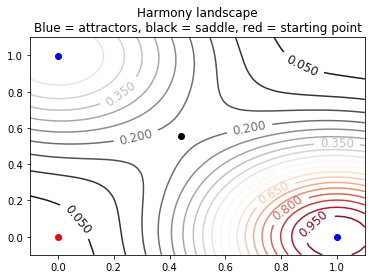

In [3]:
# Plotting the harmony landscape and fixed points
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

Hnum = lambdify(x, H)  # Making a numerical version of the symbolic function
delta = 0.025  # Grid size for calculating the harmony
xx1 = np.arange(-0.1, 1.1, delta)
xx2 = np.arange(-0.1, 1.1, delta)
Z = np.zeros((len(xx1), len(xx2)))  # Harmony
for i, j in product(range(len(xx1)), range(len(xx2))):
    Z[i, j] = Hnum(xx1[i], xx2[j])


# Making the contour plot
clines = plt.contour(xx1, xx2, Z.T, 20, cmap='RdGy_r')
plt.clabel(clines, clines.levels[::3], inline=True, fontsize=12)
# Marking the fixed pts.
plt.plot(xg[0], xg[1], marker='o', color='blue')
plt.plot(xu[0], xu[1], marker='o', color='blue')
plt.plot(xmid[0], xmid[1], marker='o', color='k')
plt.plot(0, 0, marker='o', color='red')  # init. condition
plt.title('Harmony landscape\nBlue = attractors, black = saddle, red = starting point')
plt.show()

In [4]:
# Now we can calculate the integral shown above
# Takes a few seconds...
integrand = Matrix(np.reciprocal(dxdt.subs({x0: r[0], x1: r[1]})))
integrand.dot(dr)  # 
integrand_g = (integrand.dot(dr)).subs({x0i: 0, x1i: 0, x0f: xg[0]-0.1, x1f: xg[1]-0.1})
Tg = Integral(integrand_g, (t, 0, 1)).evalf()
integrand_u = (integrand.dot(dr)).subs({x0i: 0, x1i: 0, x0f: xu[0]-0.1, x1f: xu[1]-0.1})
Tu = Integral(integrand_u, (t, 0, 1)).evalf()
print('Time to grammatical = {}\nTime to ungrammatical = {}'.format(Tg, Tu))

Time to grammatical = 0.618841121217809
Time to ungrammatical = 2.24774354722145


In [5]:
# Changing the harmony height of the ungrammatical parse:
integrand_u = (integrand.dot(dr)).subs({h1: 0.25, x0i: 0, x1i: 0, x0f: xu[0]-0.1, x1f: xu[1]-0.1})
Tu2 = Integral(integrand_u, (t, 0, 1)).evalf()
print('Time to ungrammatical (h1 = 0.25) = {}'.format(Tu2))

Time to ungrammatical (h1 = 0.25) = 5.58320971411626


### Summing up so far

So, it looks like the line integral approach is making coherent predictions about settling times to different attractors: Higher-harmony attractors are approached faster than lower-harmony ones.

The overall theory of reading times here is that the overall average time is the weighted average of how long it takes to settle to each attractor weighted by how often the system goes to that attractor. We now have predictions about how fast it takes to get to each attractor, now we want to look at how often it goes to each one.

**Let's assume dyn. w/i an attr. basin is approx. by single Gaussian, which is analytically simpler (pos. linearize w/i attr. basin).**

## Part the second: Relative harmony heights and reading times

Here's the plan for this part: Start with the two harmony peaks at the same height $h_0 = h_1 = 1.0$. Do 2000 runs (using 1000 was still a bit noisy) with $\mathbf{x}_{init} = [0, 0]^\intercal$, $h_0 = 1.0$, and $\gamma = 0.25$, recording which attractor is chosen and how long it takes. After that, I'll gradually lower $h_1$ in increments of 0.05. The hope is that the mean RT for all runs will decrease as $h_1 \rightarrow 0.0$. The lower harmony of $\mathbf{x}_1$ should, on the one hand, make approaches to it much slower, on the other hand, $\mathbf{x}_0$ will be chosen more often, so the average RT should go down.

In [6]:
# Running the Monte-Carlo simulations
import pandas as pd

centers = np.array([[1, 0], [0, 1]])
harmonies = np.array([1.0, 1.])
gamma = 0.25
ndim = centers.shape[1]
D = 0.001  # Small noise
maxsteps = 1000
tau = 0.01
xinit = np.array([0, 0.])  # starting at the midpoint between the two attractors


# Defining functions
def phi(x, center, gamma):
    """RBF centers"""
    l2norm = np.linalg.norm(x - center)
    return np.exp(-l2norm**2 / gamma)


def calc_harmony(x, centers, harmonies, gamma):
    """Calculate the harmony at a given position"""
    harmony = 0
    for c in range(centers.shape[0]):
        harmony += harmonies[c] * phi(x, centers[c], gamma)
    return harmony


def step_dyn(x, centers, harmonies, gamma):
    """Iterate the discretized dynamics"""
    dx = np.zeros(x.shape)
    mult = -2./gamma
    for c in range(centers.shape[0]):
        dx += (mult * harmonies[c]
               * (x - centers[c]) * phi(x, centers[c], gamma))
    return dx


def not_close(x, centers, tol):
    """Returns True if not close to one of the centers"""
    l2norm = np.zeros(centers.shape[0])
    for c in range(centers.shape[0]):
        diff = x - centers[c]
        l2norm[c] = np.sqrt(np.dot(diff, diff))
    if np.any(l2norm < tol):
        return False
    else:
        return True

# Running
xhist = np.zeros((maxsteps, ndim))
nruns = 1000
data_list = []
hvals = np.arange(1.0, 0.0, -0.05)

for h in range(len(hvals)):
    harmonies[1] = hvals[h]
    print('\nh_1 = {}'.format(hvals[h]))
    for run in range(nruns):
        if run % 500 == 0:
            print('[{}] '.format(run), end='')
        xhist[0,] = xinit
        noise = np.random.normal(0, 1, xhist.shape)
        t = 0
        while t < maxsteps-1:
            if not_close(xhist[t], centers, 0.1):
                xhist[t+1,] = (xhist[t,] + tau*step_dyn(xhist[t,], centers, harmonies, gamma)
                              + np.sqrt(2*D*tau)*noise[t,])
                t += 1
            else:
                break
        if np.all(np.round(xhist[t,]) == centers[0,]):
            data_list.append([hvals[h], 'A', t])
        elif np.all(np.round(xhist[t,]) == centers[1,]):
            data_list.append([hvals[h], 'B', t])
        else:
            data_list.append([hvals[h], 'Other', t])

    if nruns == 1:
        plt.plot(xhist)
        plt.show()

data = pd.concat([pd.DataFrame([i], columns=('Harmony1', 'Attractor', 'Time')) for i in data_list])


h_1 = 1.0
[0] [500] 
h_1 = 0.95
[0] [500] 
h_1 = 0.8999999999999999
[0] [500] 
h_1 = 0.8499999999999999
[0] [500] 
h_1 = 0.7999999999999998
[0] [500] 
h_1 = 0.7499999999999998
[0] [500] 
h_1 = 0.6999999999999997
[0] [500] 
h_1 = 0.6499999999999997
[0] [500] 
h_1 = 0.5999999999999996
[0] [500] 
h_1 = 0.5499999999999996
[0] [500] 
h_1 = 0.49999999999999956
[0] [500] 
h_1 = 0.4499999999999995
[0] [500] 
h_1 = 0.39999999999999947
[0] [500] 
h_1 = 0.3499999999999994
[0] [500] 
h_1 = 0.2999999999999994
[0] [500] 
h_1 = 0.24999999999999933
[0] [500] 
h_1 = 0.1999999999999993
[0] [500] 
h_1 = 0.14999999999999925
[0] [500] 
h_1 = 0.0999999999999992
[0] [500] 
h_1 = 0.049999999999999156
[0] [500] 

In [7]:
# Checking to make sure it saved alright
print(data.head())
print(data.tail())

   Harmony1 Attractor  Time
0       1.0         B   152
0       1.0         B   133
0       1.0         A   165
0       1.0         B   128
0       1.0         A   128
   Harmony1 Attractor  Time
0      0.05         A   175
0      0.05         A   181
0      0.05         A   138
0      0.05         A   143
0      0.05         A   124


In [8]:
# Basic descriptive statistics
data.groupby('Harmony1').describe()

Time                                                         
           count     mean        std    min     25%    50%     75%    max
Harmony1                                                                 
0.05      1000.0  144.371  20.806255   97.0  130.00  142.0  155.00  300.0
0.10      1000.0  144.552  21.525953  102.0  129.00  141.0  157.00  240.0
0.15      1000.0  144.206  21.894495   98.0  129.00  141.0  155.00  298.0
0.20      1000.0  144.453  20.697589  102.0  130.00  141.0  156.00  243.0
0.25      1000.0  144.807  20.654015   99.0  131.00  141.0  156.00  257.0
0.30      1000.0  145.796  21.077539  101.0  131.00  142.0  158.00  237.0
0.35      1000.0  145.888  20.626753  101.0  131.00  143.0  157.00  274.0
0.40      1000.0  147.472  22.612752  101.0  132.00  144.0  159.00  309.0
0.45      1000.0  148.677  25.782774   97.0  133.00  144.0  159.00  345.0
0.50      1000.0  149.562  24.725645  105.0  133.00  146.0  161.00  319.0
0.55      1000.0  153.136  28.784337   97.0  135.00  147.0  164.00  326.0
0.60      1000.0  153.908  26.254844  105.0  136.00  148.0  166.00  288.0
0.65      1000.0  156.185  28.757708  105.0  137.00  151.0  169.00  303.0
0.70      1000.0  157.705  30.030215  104.0  137.00  151.0  171.00  323.0
0.75      1000.0  158.510  27.630189  101.0  138.00  154.0  174.00  297.0
0.80      1000.0  158.473  28.059376  106.0  139.00  153.5  175.00  298.0
0.85      1000.0  159.598  25.317887  104.0  141.00  156.0  174.25  275.0
0.90      1000.0  158.646  25.429773  103.0  141.75  154.0  172.00  277.0
0.95      1000.0  157.439  24.490775  110.0  139.00  154.0  171.00  254.0
1.00      1000.0  152.733  22.582331  106.0  136.00  151.0  165.00  259.0

In [9]:
data.groupby(['Attractor', 'Harmony1']).describe()  # basic info by attractor

Time                                               \
                     count        mean        std    min     25%    50%   
Attractor Harmony1                                                        
A         0.05      1000.0  144.371000  20.806255   97.0  130.00  142.0   
          0.10      1000.0  144.552000  21.525953  102.0  129.00  141.0   
          0.15      1000.0  144.206000  21.894495   98.0  129.00  141.0   
          0.20      1000.0  144.453000  20.697589  102.0  130.00  141.0   
          0.25      1000.0  144.807000  20.654015   99.0  131.00  141.0   
          0.30      1000.0  145.796000  21.077539  101.0  131.00  142.0   
          0.35      1000.0  145.888000  20.626753  101.0  131.00  143.0   
          0.40       999.0  147.310310  22.038130  101.0  132.00  144.0   
          0.45       993.0  147.778449  23.419846   97.0  133.00  144.0   
          0.50       995.0  149.001005  23.362316  105.0  132.50  146.0   
          0.55       983.0  151.373347  25.338804   97.0  134.00  147.0   
          0.60       974.0  152.224846  24.166980  105.0  136.00  148.0   
          0.65       944.0  152.556144  24.209255  105.0  136.00  149.0   
          0.70       922.0  153.466377  26.018273  104.0  136.00  148.0   
          0.75       878.0  153.678815  23.929806  101.0  136.00  150.0   
          0.80       835.0  153.281437  25.105935  106.0  136.00  149.0   
          0.85       734.0  153.916894  23.184118  104.0  138.00  150.5   
          0.90       652.0  153.846626  24.425021  103.0  137.00  150.5   
          0.95       590.0  155.505085  24.891871  110.0  137.00  152.0   
          1.00       481.0  152.438669  22.232598  110.0  137.00  150.0   
B         0.40         1.0  309.000000        NaN  309.0  309.00  309.0   
          0.45         7.0  276.142857  30.140939  229.0  262.50  265.0   
          0.50         5.0  261.200000  37.399198  230.0  231.00  246.0   
          0.55        17.0  255.058824  33.125652  189.0  240.00  249.0   
          0.60        26.0  216.961538  23.853689  181.0  199.25  214.5   
          0.65        56.0  217.357143  30.603879  152.0  195.75  211.5   
          0.70        78.0  207.807692  29.070920  157.0  185.25  208.5   
          0.75       122.0  193.278689  27.647205  144.0  175.00  189.5   
          0.80       165.0  184.745455  27.549214  134.0  164.00  182.0   
          0.85       266.0  175.274436  24.363983  123.0  158.00  171.0   
          0.90       348.0  167.637931  24.862526  121.0  149.00  162.5   
          0.95       410.0  160.221951  23.655473  114.0  142.25  157.5   
          1.00       519.0  153.005780  22.919743  106.0  136.00  151.0   

                                   
                       75%    max  
Attractor Harmony1                 
A         0.05      155.00  300.0  
          0.10      157.00  240.0  
          0.15      155.00  298.0  
          0.20      156.00  243.0  
          0.25      156.00  257.0  
          0.30      158.00  237.0  
          0.35      157.00  274.0  
          0.40      159.00  305.0  
          0.45      159.00  345.0  
          0.50      160.00  319.0  
          0.55      163.00  281.0  
          0.60      163.00  288.0  
          0.65      164.25  303.0  
          0.70      167.00  323.0  
          0.75      167.00  289.0  
          0.80      165.00  271.0  
          0.85      167.00  256.0  
          0.90      166.00  277.0  
          0.95      169.75  250.0  
          1.00      164.00  259.0  
B         0.40      309.00  309.0  
          0.45      299.00  316.0  
          0.50      283.00  316.0  
          0.55      278.00  326.0  
          0.60      229.75  280.0  
          0.65      236.25  303.0  
          0.70      225.75  300.0  
          0.75      206.75  297.0  
          0.80      201.00  298.0  
          0.85      188.00  275.0  
          0.90      180.25  270.0  
          0.95      173.75  254.0  
          1.00      166.00  252.0

In [10]:
# Calculating descriptive statistics for plotting
byharmony = data.groupby(['Harmony1', 'Attractor']).agg('count')
props = byharmony.groupby(level=0).apply(lambda x: x / x.sum())
propa = props.xs('A', level=1)  # Proportions of A-parses by h1 harmony

means = data.groupby('Harmony1').describe().iloc[:, 1]  # Mean settling times

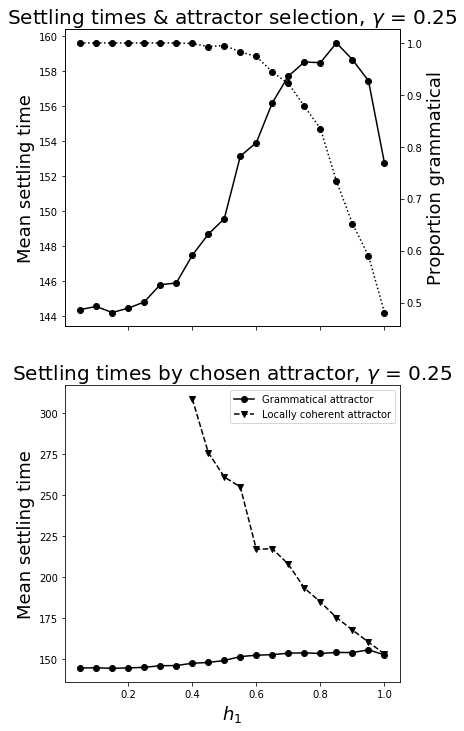

In [42]:
# Making a figure of mean settling time and proportion of gramm attractors
f, axarr = plt.subplots(2, sharex=True)
f.set_figheight(12)
f.set_figwidth(6)

ax0 = axarr[0]
ax1 = axarr[0].twinx()  # proportion grammatical
ax2 = axarr[1]  # breakdown of settling times by attr.
ax0.plot(means, 'k-o')
ax1.plot(propa, 'k:o')

#ax0.set_xlabel('$h_1$')
ax0.set_ylabel('Mean settling time', fontsize=18)
ax1.set_ylabel('Proportion grammatical', fontsize=18)
ax0.set_title('Settling times & attractor selection, $\gamma$ = {}'.format(gamma), fontsize=20)
#plt.show()

# Looking at the settling times by attractor chosen and h1
rts = data.groupby(['Attractor', 'Harmony1']).describe().iloc[:, 1]
ax2.plot(hvals[::-1], rts.xs('A'), 'k-o', label='Grammatical attractor')
ax2.plot(hvals[0:len(rts.xs('B')),][::-1], rts.xs('B'), 'k--v', label='Locally coherent attractor')
ax2.set_title('Settling times by chosen attractor, $\gamma$ = {}'.format(gamma), fontsize=20)
ax2.set_ylabel('Mean settling time', fontsize=18)
ax2.set_xlabel('$h_1$', fontsize=18)
ax2.legend()
plt.show()

f.savefig('TimesAsFnOfH1.pdf', bbox_inches='tight')

## Discussion

In this second part, we see an unexpected nonlinear relationship between the relative harmony heights and the settling times. One part of our expectation was borne out: When one attractor has high harmony and the other attractor has low harmony, the average settling times were fast. The system always chooses the high-harmony attractor, and it gets there fast due to its high harmony.

As the harmony of the lower-harmony peak increases, so does the average settling time. But this pattern only holds for a while. After the lower-harmony peak reaches about $h_1 = 0.9$, the average settling time starts to *decrease*. This is because the system starts choosing the lower-harmony peak more often at the same as it's getting faster to approach that attractor. When the two attractors have equal harmony (1.0), the average reading time is still higher than when the two were very unbalanced in harmony.

This makes a really interesting and, as far as I know, unique prediction for sentence processing. When there are two parses available, one high- and one low-harmony, reading times should be fast because the parser will easily choose the high-harmony parse. Reading times should be slower when the two parses are evenly matched in harmony. But this  competition-based slowdown should actually be stronger when the competing parses are only slightly unbalanced in their well-formedness.

The tricky news: picking the $h_i$ is really important because of the nonlinear relationship between it and settling times. 

Model is generally plausible: it seems to get things roughly right, esp. increasing green curve for high competition makes sense for a lot of psycholing. data. But there's a non-trivial subtlety in the up ranges that hasn't been tested yet.

Ambiguity advantage?: "the driver/car of the car/driver with the mustache" both show interference, which might be part of upper part of green curve. Some (Vasishth, Ferreira) seem to want dual attch., but we might expect this to fall out of nature of dyn.... Something like GP would be big difference between harmonies of competitors.

Need compelling reason to use this approach, and then say, "Look, it makes this really cool prediction." Selling points: predicts errant behaviors via normal processing, and we have principled analysis to understand them. 

**Look at how the green curve relates to the black and red ones: is it just weighted by the blue curve.**

**Pos. have one simpler model for illustration/details and another full-fledged one for generality.**

# Part the third: Varying gamma and h together -> 3D plot

Track down PW's comment on rel. mag. of eigenvalues of dyn. and noise mag.: There, he was concerned with the baseline constraint, the strength of which should be greater than the largest absolute eigenvalue of the grammatical weight matrix. For our purposes, I think we can make an analogous approach: For the deterministic dynamics to dominate trajectories near a fixed point, the eigenvalues of the Jacobian matrix should be larger than the eigenvalues of the noise magnitude matrix. Since the noise magnitude matrix is a diagonal matrix with identical values $D$, the largest absolute eigenvalue of the Jacobian should be greater than $D = 0.001$.

If gamma gets too large, we only have a single peak (blend state), but if it's too small, it's just a random walk in a flat harmony landscape. 

[//]: # (Also, what does gamma mean *in the theory*? Part of a theory of learning?)

For the simulations below, I will do 1000 runs of the system keeping $h_0$ constant and varying both $\gamma$ and $h_1$. Muezzinoglu & Zurada (2006) show that for equal $\gamma$s and two attractors, there will be separate attractors as long as $\gamma < \Vert\mathbf{c}_0 - \mathbf{c}_1\Vert_2^2 / 2$. Since the centers are at [1, 0] and [0, 1], $\gamma$ should be less than $\frac{\sqrt{2}}{2} \approx 0.71$ and greater than $D = 0.001$. $h_1$ will range from 0.1 to 1.0. I don't know how well this holds for unequal $\gamma$s, though...

In [ ]:
# Running the simulations
xhist = np.zeros((maxsteps, ndim))
nruns = 1000
data_list = []
gridsize = 0.07
hvals = np.arange(0.1, 1.1, gridsize)
gvals = np.arange(0.1, 0.8, gridsize)

for g in range(len(gvals)):
    gamma = gvals[g]
    print('gamma = {}'.format(gamma))
    for h in range(len(hvals)):
        harmonies[1] = hvals[h]
        print('h_1 = {}'.format(hvals[h]), end=' ')
        for run in range(nruns):
            #if run % 100 == 0:
            #    print('[{}] '.format(run), end='')
            xhist[0,] = xinit
            noise = np.random.normal(0, 1, xhist.shape)
            t = 0
            while t < maxsteps-1:
                if not_close(xhist[t], centers, 0.1):
                    xhist[t+1,] = (xhist[t,] + tau*step_dyn(xhist[t,], centers, harmonies, gamma)
                                   + np.sqrt(2*D*tau)*noise[t,])
                    t += 1
                else:
                    break
            if np.all(np.round(xhist[t,]) == centers[0,]):
                data_list.append([gvals[g], hvals[h], 'A', t])
            elif np.all(np.round(xhist[t,]) == centers[1,]):
                data_list.append([gvals[g], hvals[h], 'B', t])
            else:
                data_list.append([gvals[g], hvals[h], 'Other', t])


In [ ]:
data2 = pd.concat([pd.DataFrame([i], columns=('Gamma', 'Harmony1', 'Attractor', 'Time')) for i in data_list])

In [ ]:
data2.groupby(['Gamma', 'Harmony1']).describe()

In [ ]:
data2.head()

In [ ]:
agg2 = data2.groupby(['Gamma', 'Harmony1'], as_index=False).aggregate(np.mean)
agg2.head()

In [ ]:
%matplotlib notebook

In [ ]:
# Plotting the surface
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(agg2.Gamma, agg2.Harmony1, agg2.Time, linewidth=0.5, antialiased=True)
ax.set_xlabel('Gamma')
ax.set_ylabel('Harmony1')
ax.set_zlabel('Mean settling time')
plt.show()

In [ ]:
# For gamma < 0.2, it basically never finds an attractor, so let's zoom in, leaving that out
agg_subset = agg2.loc[agg2.Gamma > 0.1,]
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(agg_subset.Gamma, agg_subset.Harmony1, agg_subset.Time, linewidth=0.5, antialiased=True)
ax.set_xlabel('$\gamma$')
ax.set_ylabel('$h_1$')
ax.set_zlabel('Mean settling time')
plt.show()

**check stopping criterion for this, although, for $\gamma <= 0.7$, there should be separate attractors**

In [ ]:
# Plotting mean RTs as a fn. of h1, with a separate curve for each value of gamma
plt.figure()
for g in gvals[::-1]:
    plt.plot(agg2.loc[agg2.Gamma == g].Harmony1, agg2.loc[agg2.Gamma == g].Time, color=str(g), label=g)
plt.legend(title='$\gamma$')
plt.ylabel('Mean settling time')
plt.xlabel('$h_1$')
plt.show()

Maybe consider only using $\gamma$ values that produce at least a 10% increase in reading times as competition increases (max. diff.)

## Notes 27.02.

The continuation/numerical bifurcation analysis in the relevant notebook has shown that the 1D SOSP system is a cusp system: When $h_0 = h_1$, then there's a simple pitchfork bifurcation at $\gamma = 0.5$ in which the two harmony peaks merge into single peak at $x^* = 0.5$. But when $h_0 \neq h_1$, the bifurcation is imperfect (Strogatz, 1994): the high-harmony peak continues, eventually moving to about $x^* = 0.5$, but the low-harmony peak only exists for $\gamma <\approx 0.4$, where it (and an unstable fixed point at about $x^* = 0$) appear in a saddle-node bifurcation.

For ICCM, it will probably work to keep $\gamma$ around 0.25 and have the minimal $h_1$ be around 0.4 or so. Whit won't like this, but whatever...